In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
from efn_util import drawEtas
from scipy.stats import multivariate_normal
from plot_utils import plotContourNormal, Dirichlet, draw_pdf_contours, plotContourTruncatedNormal
import seaborn as sns

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

exp_fam = 'prp_tn';
D = 2;
K = 1;

eta, param_net_inputs, params = drawEtas(exp_fam, D, K, False);
mus = params['mu'];
Sigmas = params['Sigma'];
xs = params['x'];
lambda_x = params['lambda'];

mu = mus[0];
Sigma = Sigmas[0];
x = xs[0];


In [2]:
"""
plt.figure();
H, xedges, yedges = np.histogram2d(x[0], x[1], bins=10, normed=True)
plt.imshow(H, origin='lower', interpolation='sinc');
plt.show();

mu = np.zeros((2,));
Sigma = np.array([[1, 0], [0, 1]]);
plotContourNormal(mu, Sigma, 100);

alpha = [1, 2, 3];
draw_pdf_contours(Dirichlet(alpha), subdiv=4);

mu = np.array([1, 5]);
Sigma = np.array([[1, .5], [.5, 1]]);
plotContourTruncatedNormal(mu, Sigma, 10, 10, 100);
"""

"\nplt.figure();\nH, xedges, yedges = np.histogram2d(x[0], x[1], bins=10, normed=True)\nplt.imshow(H, origin='lower', interpolation='sinc');\nplt.show();\n\nmu = np.zeros((2,));\nSigma = np.array([[1, 0], [0, 1]]);\nplotContourNormal(mu, Sigma, 100);\n\nalpha = [1, 2, 3];\ndraw_pdf_contours(Dirichlet(alpha), subdiv=4);\n\nmu = np.array([1, 5]);\nSigma = np.array([[1, .5], [.5, 1]]);\nplotContourTruncatedNormal(mu, Sigma, 10, 10, 100);\n"

In [3]:
import tensorflow as tf
savedir = '/Users/sbittner/Documents/efn/results/MK/tb/MEFN_prp_tn_D=2_flow=11P_rs=0/';

# Later, launch the model, use the saver to restore variables from disk, and
# do some work with the model.
sess = tf.Session();
new_saver = tf.train.import_meta_graph(savedir + 'model.meta');
new_saver.restore(sess, tf.train.latest_checkpoint(savedir));
Z0 = tf.get_collection('Z0')[0];
X = tf.get_collection('X')[0];
eta = tf.get_collection('eta')[0];
log_p_zs = tf.get_collection('log_p_zs')[0];


INFO:tensorflow:Restoring parameters from /Users/sbittner/Documents/efn/results/MK/tb/MEFN_prp_tn_D=2_flow=11P_rs=0/model


Tensor("Placeholder:0", shape=(?, ?, 2, 1), dtype=float64)
Tensor("Exp_12:0", shape=(?, ?, 2, ?), dtype=float64)
Tensor("Placeholder_1:0", shape=(?, 8), dtype=float64)
Tensor("sub_22:0", shape=(?, ?), dtype=float64)
(1, 8)


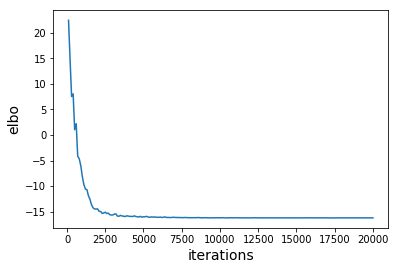

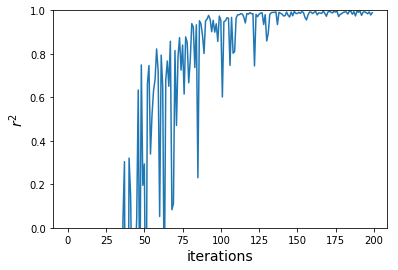

In [4]:
fontsize = 14;
print(Z0);
print(X);
print(eta);
print(log_p_zs);

fname = savedir + 'results.npz';
npzfile = np.load(fname);
params = npzfile['params'][()];
_eta = npzfile['eta'];
print(_eta.shape);
_X = npzfile['X'];
train_elbos = npzfile['train_elbos'];
train_R2s = npzfile['train_R2s'];

check_rate = 100;
n = train_elbos.shape[0];
its = check_rate*np.arange(1,n+1);
plt.figure();
plt.plot(its, train_elbos);
plt.xlabel('iterations', fontsize=fontsize)
plt.ylabel('elbo', fontsize=fontsize);
plt.show();

plt.figure();
plt.plot(train_R2s);
plt.xlabel('iterations', fontsize=fontsize);
plt.ylabel('$r^2$', fontsize=fontsize);
plt.ylim([0, 1]);
plt.show();

1/30
2/30
3/30
4/30
5/30
6/30
7/30
8/30
9/30
10/30
11/30
12/30
13/30
14/30
15/30
16/30
17/30
18/30
19/30
20/30
21/30
22/30
23/30
24/30
25/30
26/30
27/30
28/30
29/30
30/30


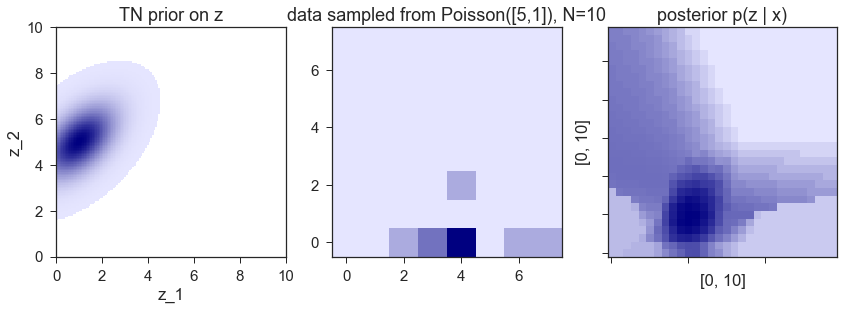

In [24]:
def closest(sess,support_point,n,X,Z0,eta,_eta):
    #constructs an nxn grid and gives back the point on the grid which, after being transformed by the network
    #is closest to simplex_point
    x = np.linspace(-3.5,3.5,n)
    clos = np.array([[x[0],x[0]]])
    feed_dict = {Z0:np.expand_dims(np.expand_dims(clos, 0), 3), eta:_eta};
    _X = sess.run(X, feed_dict);
    dist = np.linalg.norm(support_point-_X[0,0,:,0]);
    for i in range(n):
        for j in range(n):
            aux_clos = np.array([[x[i],x[j]]]);
            feed_dict = {Z0:np.expand_dims(np.expand_dims(aux_clos, 0), 3), eta:_eta};
            _X = sess.run(X, feed_dict);
            aux_dist = np.linalg.norm(support_point-_X[0,0,:,0]);
            if aux_dist<dist:
                clos = aux_clos
                dist = aux_dist
    return(clos)

def plotPoissonRatePosterior(sess, X, Z0, eta, _eta, xlim, ylim, n_plot):
    x1 = np.linspace(0, xlim, n_plot)
    x2 = np.linspace(0, ylim, n_plot)
    sns.set_palette(sns.color_palette("Set1", n_colors=8, desat=.6))
    sns.set_style("whitegrid")
    sns.set_style("ticks")
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})
    sbpal = sns.color_palette()
    
    Z = np.zeros([n_plot,n_plot])
    for i in range(n_plot):
        print('%d/%d\r' % (i+1, n_plot));
        for j in range(n_plot):
            support_point = np.array([[x1[i],x2[j]]])
            z0 = closest(sess,support_point,n_plot,X,Z0,eta,_eta);
            log_p_z_ij = sess.run(log_p_zs, {Z0:np.expand_dims(np.expand_dims(z0,0),3), eta:_eta});
            Z[i,j] = log_p_z_ij[0,0];
            
    mycm = sns.light_palette("navy", as_cmap=True)
    mycm.set_under('w')
    plt.imshow(Z.T, cmap=mycm, origin='lower')
    ax = plt.gca()
    ax.set_xlabel([0,xlim]);
    ax.set_xticklabels([]);
    ax.set_ylabel([0,ylim]);
    ax.set_yticklabels([]);
    plt.title("posterior p(z | x)")
    return Z;

mu = params['mu'];
Sigma = params['Sigma'];
xs = params['x'];
x = xs[0];
xlim = 10;
ylim = 10;
plt.figure(figsize=(14, 6));
plt.subplot(1,3,1);
plotContourTruncatedNormal(mu[0], Sigma[0], xlim, ylim, 100, 'TN prior on z', scatter=False);
plt.xlabel('z_1');
plt.ylabel('z_2');

plt.subplot(1,3,2);
mycm = sns.light_palette("navy", as_cmap=True)
mycm.set_under('w')
plot_range = [[0, xlim], [0, ylim]];
H, xedges, yedges = np.histogram2d(x[0], x[1], bins=8, range=plot_range, normed=True)
plt.imshow(H.T, origin='lower', interpolation='none', cmap=mycm);
plt.title('data sampled from Poisson([5,1]), N=10');
#plt.colorbar();


plt.subplot(1,3,3);
xlim = 10;
ylim = 10;
n_plot = 30;
Z = plotPoissonRatePosterior(sess, X, Z0, eta, _eta, xlim, ylim, n_plot);
plt.show();